This new notebook will directly address the class imbalance issue using the SMOTE (Synthetic Minority Over-sampling Technique) on the training data. This will create a balanced dataset for the models to learn from, which should significantly improve their ability to detect fraudulent claims.

The goal is to rebalance the dataset by either creating more fraud samples or reducing the number of legitimate samples.

In [2]:
!pip install imbalanced-learn -q

In [ ]:
pip install --upgrade imbalanced-learn


In [2]:
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# --- 2. Load Processed Data ---
try:
    train_df = pd.read_csv('data/train_processed.csv')
    test_df = pd.read_csv('data/test_processed.csv')
    print("Processed training and testing data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure 'train_processed.csv' and 'test_processed.csv' are in the 'data/' subdirectory.")

# Prepare data for modeling
X_train = train_df.drop('FRAUD_FLAG', axis=1)
y_train = train_df['FRAUD_FLAG']
X_test = test_df.drop('FRAUD_FLAG', axis=1)
y_test = test_df['FRAUD_FLAG']

Processed training and testing data loaded successfully.


Apply SMOTE to Handle Class Imbalance

This is the key step. We will use SMOTE to oversample the minority class (fraud) only in the training set to prevent data leakage.

In [5]:
# --- 3. Apply SMOTE to the Training Data ---
print("Original training data distribution:")
print(y_train.value_counts())

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and apply the transform
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled training data distribution:")
print(y_train_resampled.value_counts())

print("\nShape of resampled training data:", X_train_resampled.shape)

Original training data distribution:
FRAUD_FLAG
0    7598
1     402
Name: count, dtype: int64

Resampled training data distribution:
FRAUD_FLAG
0    7598
1    7598
Name: count, dtype: int64

Shape of resampled training data: (15196, 2115)


 Re-train Models on Balanced Data
 
Now we train the same four models, but this time on the balanced _resampled data. 

In [6]:
# --- 4a. Logistic Regression on Resampled Data ---
print("--- Training Logistic Regression on Resampled Data ---")
lr_model_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_lr_smote = lr_model_smote.predict(X_test)
y_prob_lr_smote = lr_model_smote.predict_proba(X_test)[:, 1]
print("Logistic Regression Performance (SMOTE):")
print(classification_report(y_test, y_pred_lr_smote))

# --- 4b. Random Forest on Resampled Data ---
print("\n--- Training Random Forest on Resampled Data ---")
rf_model_smote = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_rf_smote = rf_model_smote.predict(X_test)
y_prob_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]
print("Random Forest Performance (SMOTE):")
print(classification_report(y_test, y_pred_rf_smote))

# --- 4c. XGBoost on Resampled Data ---
print("\n--- Training XGBoost on Resampled Data ---")
xgb_model_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_xgb_smote = xgb_model_smote.predict(X_test)
y_prob_xgb_smote = xgb_model_smote.predict_proba(X_test)[:, 1]
print("XGBoost Performance (SMOTE):")
print(classification_report(y_test, y_pred_xgb_smote))

# --- 4d. LightGBM on Resampled Data ---
print("\n--- Training LightGBM on Resampled Data ---")
lgbm_model_smote = LGBMClassifier(random_state=42)
lgbm_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_lgbm_smote = lgbm_model_smote.predict(X_test)
y_prob_lgbm_smote = lgbm_model_smote.predict_proba(X_test)[:, 1]
print("LightGBM Performance (SMOTE):")
print(classification_report(y_test, y_pred_lgbm_smote))

--- Training Logistic Regression on Resampled Data ---
Logistic Regression Performance (SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1899
           1       0.06      0.15      0.08       101

    accuracy                           0.83      2000
   macro avg       0.50      0.51      0.49      2000
weighted avg       0.91      0.83      0.87      2000


--- Training Random Forest on Resampled Data ---
Random Forest Performance (SMOTE):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1899
           1       0.00      0.00      0.00       101

    accuracy                           0.95      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.90      0.95      0.92      2000


--- Training XGBoost on Resampled Data ---
XGBoost Performance (SMOTE):
              precision    recall  f1-score   support

           0       0.95      1.00    

Analyze New Model Performance

In [7]:
# --- 5a. Model Performance Comparison Table (SMOTE) ---
model_performance_smote = {
    'Logistic Regression': {
        'AUC-ROC': roc_auc_score(y_test, y_prob_lr_smote),
        'Precision (Fraud)': precision_score(y_test, y_pred_lr_smote),
        'Recall (Fraud)': recall_score(y_test, y_pred_lr_smote),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_lr_smote)
    },
    'Random Forest': {
        'AUC-ROC': roc_auc_score(y_test, y_prob_rf_smote),
        'Precision (Fraud)': precision_score(y_test, y_pred_rf_smote),
        'Recall (Fraud)': recall_score(y_test, y_pred_rf_smote),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_rf_smote)
    },
    'XGBoost': {
        'AUC-ROC': roc_auc_score(y_test, y_prob_xgb_smote),
        'Precision (Fraud)': precision_score(y_test, y_pred_xgb_smote),
        'Recall (Fraud)': recall_score(y_test, y_pred_xgb_smote),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_xgb_smote)
    },
    'LightGBM': {
        'AUC-ROC': roc_auc_score(y_test, y_prob_lgbm_smote),
        'Precision (Fraud)': precision_score(y_test, y_pred_lgbm_smote),
        'Recall (Fraud)': recall_score(y_test, y_pred_lgbm_smote),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_lgbm_smote)
    }
}
performance_df_smote = pd.DataFrame(model_performance_smote).T
print("\n--- Overall Model Performance Summary (with SMOTE) ---")
print(performance_df_smote)


--- Overall Model Performance Summary (with SMOTE) ---
                      AUC-ROC  Precision (Fraud)  Recall (Fraud)  \
Logistic Regression  0.561348            0.05618        0.148515   
Random Forest        0.533149            0.00000        0.000000   
XGBoost              0.563616            0.00000        0.000000   
LightGBM             0.551776            0.00000        0.000000   

                     F1-Score (Fraud)  
Logistic Regression          0.081522  
Random Forest                0.000000  
XGBoost                      0.000000  
LightGBM                     0.000000  


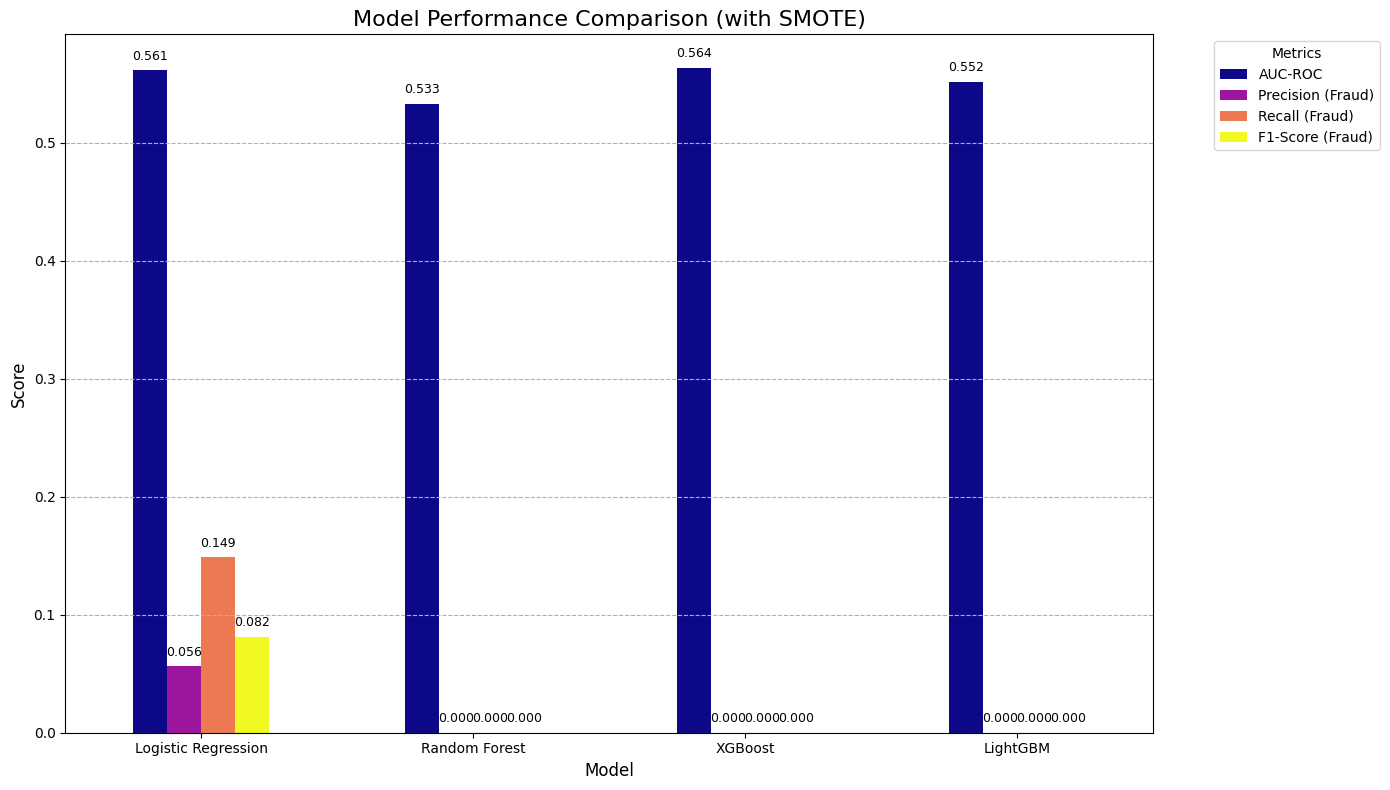

In [8]:
# --- 5b. Visualize Model Performance Comparison (SMOTE) ---
ax = performance_df_smote.plot(kind='bar', figsize=(14, 8), colormap='plasma')
plt.title('Model Performance Comparison (with SMOTE)', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)
plt.show()


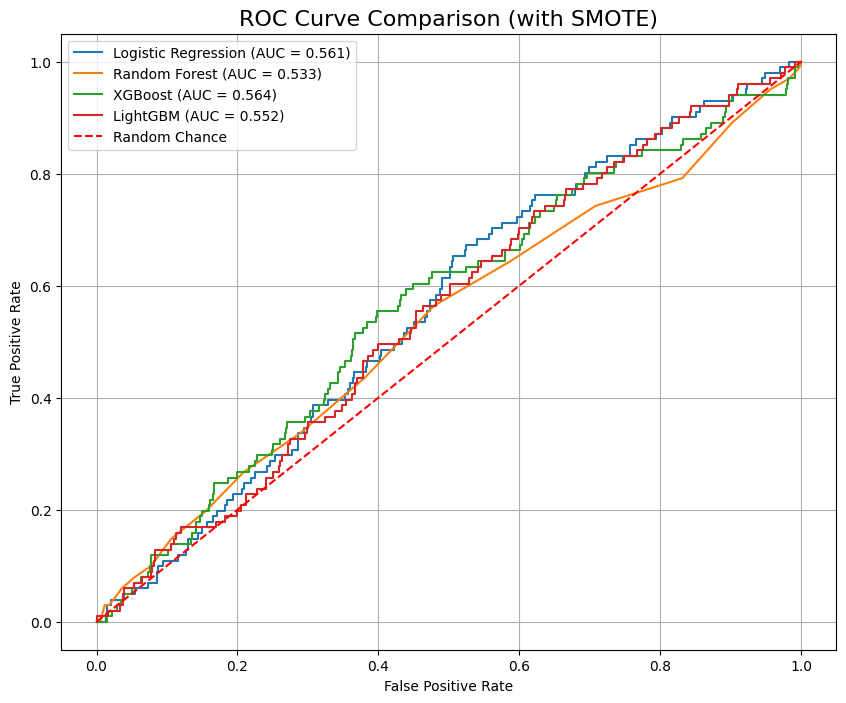

In [9]:
# --- 5c. Plot ROC Curves (SMOTE) ---
plt.figure(figsize=(10, 8))
# Add curves for each model
models = {
    'Logistic Regression': y_prob_lr_smote,
    'Random Forest': y_prob_rf_smote,
    'XGBoost': y_prob_xgb_smote,
    'LightGBM': y_prob_lgbm_smote
}
for name, prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance')
plt.title('ROC Curve Comparison (with SMOTE)', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

[CONCLUSIONS]

Why did SMOTE not work, and what should be done next?

This experiment did not fail, but was successful in diagnosing problems. We have learned that the problem is not only the amount of fraudulent samples, but probably the quality of the features.

 These models demonstrate that due to existing characteristics, it is difficult to define consistent patterns to distinguish valid claims from actual fraud. To bridge this gap, SMOTE synthetic data proved to be insufficient.

